### GW tutorial 3: Generation of data and matched filtering

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [1]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd, pycbc.noise
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import random

Previously, we have plotted the PSD of different detectors. Some PSDs are from previous runs (O3), while some others are the design sensitivity of future detectors.

The PSD characterizes the noise of the detector, so we can generate detector noise accordingly.

**Exercise 1:** Load the `aligo_O4high.txt` PSD to [generate](https://pycbc.org/pycbc/latest/html/pycbc.noise.html#pycbc.noise.gaussian.noise_from_psd) some Gaussian data.

_Hint:_ Minimum frequency is 10 Hz, sampling rate 4096 Hz and we want 20s of duration

Text(0, 0.5, 'Amplitude (dimensionless)')

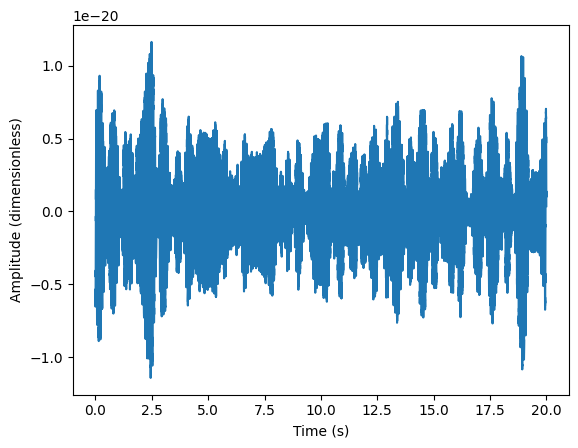

In [2]:
# Solution

flow = 12 # Lower cutoff frequency
sampling_rate = 4096.
duration = 20

delta_f = 1.0/duration
delta_t = 1/sampling_rate

flen = int(1/(delta_f*delta_t)) + 1 # number of data points

path_to_asds = "./sensitivity_curves/"
file_psd = path_to_asds + "aligo_O4high.txt"
psd = pycbc.psd.read.from_txt(file_psd, flen, delta_f, flow, is_asd_file= True)

noise = pycbc.noise.noise_from_psd(flen, delta_t, psd, seed=42)

plt.plot(noise.sample_times, noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (dimensionless)')

As you can see. the generated noise is "coloured" according to the detector noise. Now, we would like to add a simulated gravitational wave signal in our detector noise. 

**Exercise 2:** Using [this function](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform) to generate waveforms in time domain, provide the plus and cross polarization of a binary black hole merger of $m_{1} = m_{2} = 50$ at 2000 Mpc. Use the waveform approximant "IMRPhenomD". How does the waveform amplitude compare to the detector noise?

The waveform comes from the source, but it needs to be projected in the detector. [Project](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector.project_wave) the waveform on LIGO Livingston (L1) at random sky-location and polarization. You can specify your detector with [this](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector) function. How does the waveform change because of this projection?

_Hint:_ Right ascension range is $[0, 2\pi]$, declination is $[-2\pi, 2\pi]$ and polarization is $[0, 2\pi]$.

Text(0, 0.5, 'Amplitude')

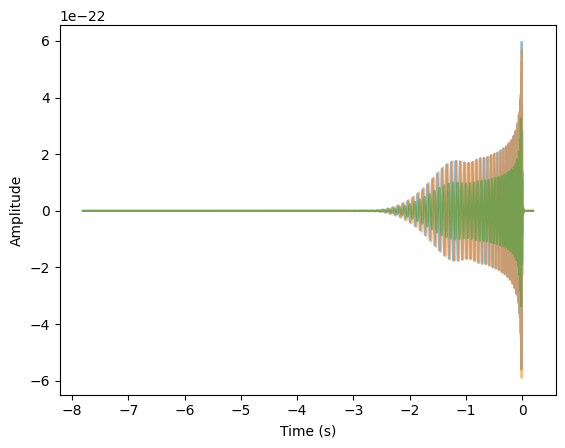

In [3]:
# Solution

# Parameters
dist = 2000
mass1, mass2 = 50, 50,
ifo = 'L1'
ra = random.uniform(0, 2 * np.pi)
dec = random.uniform(- 2 * np.pi, 2 * np.pi)
pol = random.uniform(0, 2 * np.pi)

# Generate the waveform
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=mass1,
                         mass2=mass2,
                         delta_t=delta_t,
                         distance = dist,
                         f_lower=flow) 
plt.plot(hp.sample_times, hp, alpha=0.5, label=r'$h_{+}$')
plt.plot(hp.sample_times, hc, alpha=0.5, label=r'$h_{\times}$')

projection = Detector(ifo).project_wave(hp, hc, ra, dec, pol)

plt.plot(projection.sample_times, projection, alpha=0.5, label=r'Projection')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

**Exercise 2:** From before our detector noise is 20s long. Add the GW into noise after 5s. We also need to get the first 4s to estimate the PSD in the next excercise. Make an overlaid plot with the total data, the portion of data where the GW is added and the data needed to estimate the PSD. 

_Bonus:_ Can you also plot the GW signal? 


Text(0, 0.5, 'Amplitude (dimensionless)')

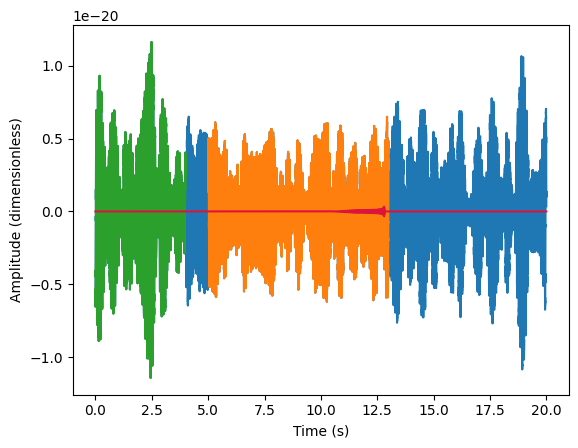

In [4]:
# Solution

t_start = 5
scratch_time = 4
scratch_bin = int(scratch_time * sampling_rate)
start_bin = int(sampling_rate * t_start)
end_bin = start_bin + projection.shape[0]

# We inject the GW signal
noise.data[start_bin:end_bin] = noise.data[start_bin:end_bin] + projection.data

plt.plot(noise.sample_times, noise, label='All noise')
plt.plot(noise.sample_times[start_bin:end_bin], noise[start_bin:end_bin], label='GW present')
plt.plot(noise.sample_times[:scratch_bin], noise[:scratch_bin], label='Data to estimate PSD')

# Bonus! I pad waveform with zeros so we can plot it
tmp = np.concatenate([np.zeros(start_bin),projection.data,  np.zeros(noise.shape[0] - end_bin)])
plt.plot(noise.sample_times, tmp, c='crimson')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (dimensionless)')
#noise.data[start_bin:end_bin] + projection.data

**Exercise 3:** In a proper search we do not really have the PSD handy. We want to estimate the PSD with Welch's method (see [here](https://ccrma.stanford.edu/~jos/sasp/Welch_s_Method.html) for details), but we want to use the 4s of the beginning where the GW is not present using [this function](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.welch). Plot the estimated PSD. Note that before we used a dummy whitening, and this one is a bit better.

What is the $\Delta_f$ of the estimated PSD? What is $\Delta_f$ of the data we want to whiten to see the GW signal?

_Hint:_ `seg_stride (int)` is usually half of `seg_len`.


'The estimated delta_f = 0.25, while the data has delta_f 0.05'

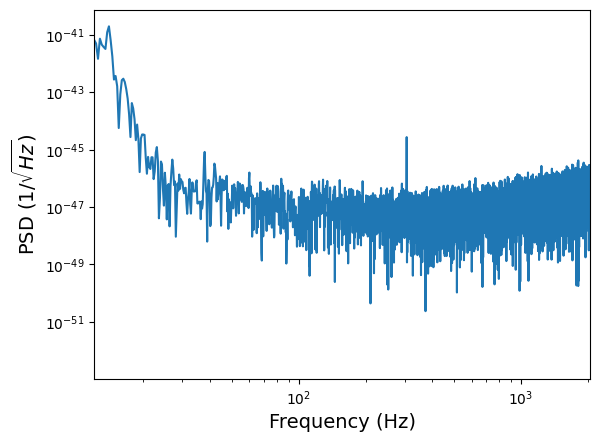

In [5]:
# Solution
data = noise.copy()
scratch_time = 4
scratch_bin = int(scratch_time * sampling_rate)
seg_stride = int(scratch_bin / 2)

scratch = data[:scratch_bin]

# We estimate the PSD with Welch's method
rec_psd = pycbc.psd.welch(scratch,
                seg_len=scratch_bin,
                seg_stride=seg_stride)

plt.loglog(rec_psd.sample_frequencies, rec_psd)
plt.xlim(flow, sampling_rate/2) # limit int low frequency and
plt.xlabel('Frequency (Hz)', size = 14)
plt.ylabel(r'PSD $(1/\sqrt{Hz})$', size= 14)

f'The estimated delta_f = {rec_psd.delta_f}, while the data has delta_f {np.round(data.delta_f, 3)}'

Now that we have the PSD we need to interpolate it to match our data and then limit the filter length of 1 / PSD. After this, we can directly use this PSD to filter the data. Since the data has been highpassed above 12 Hz, and will have low values below this we need to informat the function to not include frequencies below this frequency. 

**Exercise 4:** Use the functions [interpolate](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.interpolate) and [inverse_spectrum_truncation](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.inverse_spectrum_truncation) to achieve a proper formatting of the PSD.

_Hint:_ `max_filter_len (int)` is $4 \times$ sampling_rate. Note that the original PSD has a minimum frequency of 12Hz.

In [6]:
# Solution

rec_psd = pycbc.psd.interpolate(rec_psd, data.delta_f)

rec_psd = pycbc.psd.inverse_spectrum_truncation(rec_psd, 
                                                int(4 * data.sample_rate), 
                                                low_frequency_cutoff=flow)

Now that the PSD is ready, we can whiten the data. Before we used a PyCBC function, but mathematically this is defined as

\begin{equation}
\tilde{d_w}(f) = \tilde{d}(f)/S_{n}^{-1/2}(f)
\end{equation}
where $\tilde{d}$ and $\tilde{d_w}(f)$ are the Fourier transform of the coloured data and whitened data, respectively.

**Exercise 5:** Whiten the data using the interpolated PSD. Crop 5s at the beginning and the end to avoid border effects (_aliasing_) and bandpass it as in the previous exercise. Can you see the GW signal?

Text(0, 0.5, 'Amplitude (dimensionless)')

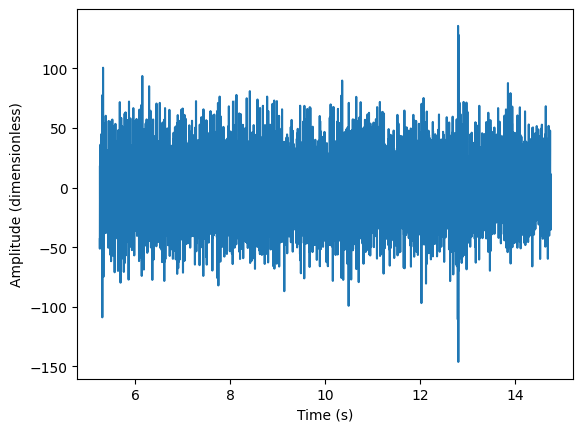

In [7]:
# Solution

# rec_psd has 1 value more (oops)
data_whitened = (data.to_frequencyseries() / rec_psd[:-1] ** 0.5).to_timeseries()
data_whitened = data_whitened.crop(5,5)
data_whitened = data_whitened.highpass_fir(30, 512).lowpass_fir(250, 512)

plt.plot(data_whitened.sample_times, data_whitened, label='Whitened data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (dimensionless)')


So far, we buried a GW signal  $h(t)$ in stationary and Gaussian noise $n(t)$ with zero mean, such that $s(t) = h(t) + n(t)$. Given the optimal filter  $K(t)$, 

\begin{equation}
\label{eq:filteredsignal}
\hat{s} = \int_{-\infty}^{\infty}  K(t)s(t) dt = \int_{-\infty}^{\infty} \tilde{K}(f)^{*}\tilde{s}(f) df, \quad \text{ where }  \tilde{s}(f) = \int_{-\infty}^{\infty} s(t)e^{-2 \pi i ft}dt
\end{equation}
where $\hat{s}$ is the filtered value of $s(t)$, $^*$ represents the complex conjugate, and $\tilde{\cdot }\ $ the Fourier transform. 

The detection statistic that is maximised by the optimal filter $K(t)$  will be the SNR, defined as $\rho = S/N$. $S$ is the expected value of $\hat{s}$ when $h(t) \neq 0$, while $N$ is the squared root of the noise variance when $h(t) =0$. It can be demonstrated that the optimal filter $K(t)$ is the model of the GW signal itself, known as _template_.

The fundamental modelled detection technique is called "matched filtering", since the filter function is chosen to "match" the signal we are looking for. We can write the SNR between an unknown time series $s(t)$ and the template $h_{m}$ as

\begin{equation}
\label{eq:wienerscalar}
\rho =  4 \text{Re} \int_{0}^{\infty} \frac{\tilde{s}^{*}(f)}{S_{n}(f)} \tilde{h_{m}}(f) df. 
\end{equation}



**Exercise 6:** Use the [matched_filter](https://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.matchedfilter.matched_filter) function to filter the coloured data with the template. Crop the SNR time series 5s at each side and plot it together with the whitened data. Where is the GW signal? Note that the y-axis of the whitened data is _amplitude_ and the y-axis of the SNR timeseries is _SNR_.

How much is the maximum of the absolute value of the SNR time series? If it is larger than 5 it will generate a "trigger" for further analysis. Will the trigger be generated?

Note that the parameter space of GW signals is vast, so to find these signals, we will need to create a template bank and do this process for thousands of templates. Then, this becomes a high-performance computing problem!

_Hint_: you need to [resize](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.array.Array.resize) the template and use [cyclic_time_shift](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.frequencyseries.FrequencySeries.cyclic_time_shift)

/home/melissa.lopez/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


25.259500060477137


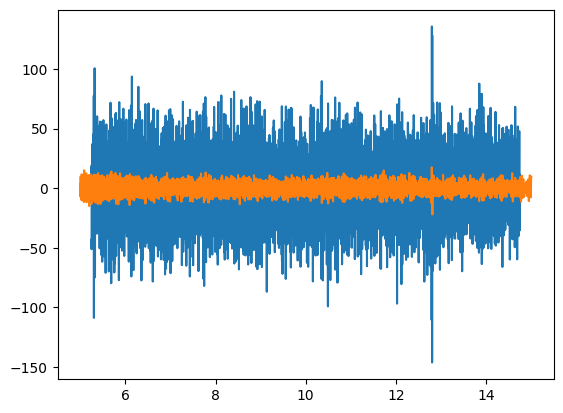

In [8]:
# Solution

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template = hp.copy()
template.resize(len(data))
template = template.cyclic_time_shift(hp.start_time)

snr_timeseries = pycbc.filter.matched_filter(template, data,
                                            psd=rec_psd, low_frequency_cutoff=flow)
snr_timeseries = snr_timeseries.crop(5,5)

plt.plot(data_whitened.sample_times, data_whitened)

plt.plot(snr_timeseries.sample_times, snr_timeseries.data)

print(max(np.abs(snr_timeseries.data)))

Good job arriving at the end of the tutorial! This was a small peak at GW data analysis that I hope you found interesting. 

There is a bonus track exercise if you are bored, but we can also have a chat about some more GW data analysis if you prefer. 